In [8]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

pd.options.display.max_rows = 8  
%matplotlib inline

读取数据

In [2]:
national_debt = pd.read_csv('data/national_debt_5y.csv',header=0,index_col = 0,encoding = 'gb2312')  # 读取股票文件
national_debt['涨跌幅'] = national_debt['涨跌幅'].str.strip("%").astype(float)/100
national_debt.head()
national_debt.describe()

,开盘,收盘,高,低,涨跌幅
日期,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.0078
2016/1/22,2.705,2.689,2.705,2.682,-0.0041
2016/1/25,2.750,2.694,2.750,2.680,0.0019
2016/1/26,2.703,2.738,2.740,2.690,0.0163
2016/1/27,2.763,2.774,2.783,2.763,0.0131


,开盘,收盘,高,低,涨跌幅
count,1563.000000,1563.000000,1563.000000,1563.000000,1.563000e+03
mean,3.041862,3.022280,3.049060,3.010074,4.478567e-07
std,0.419688,0.420101,0.418939,0.420670,9.475657e-03
min,1.740000,1.740000,1.740000,1.740000,-5.850000e-02
25%,2.746000,2.712000,2.750000,2.697000,-4.350000e-03
50%,3.012000,2.993000,3.018000,2.983000,0.000000e+00
75%,3.261000,3.234000,3.269000,3.219000,4.300000e-03
max,4.000000,3.968000,4.000000,3.952000,6.070000e-02


开盘价原始数据可视化

<Figure size 432x288 with 0 Axes>

D:\Anaconda3\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda3\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26399 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda3\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30424 missing from current font.
  f

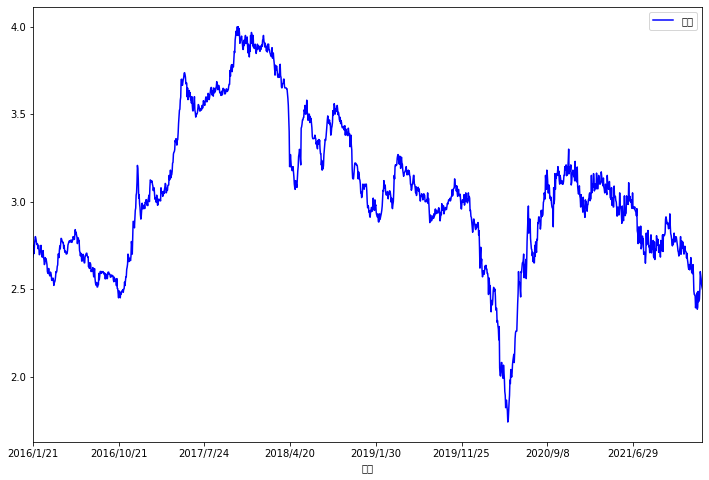

In [3]:
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue',figsize=(12,8))
    plt.show()
    
draw_ts(pd.DataFrame(national_debt['开盘']))

数据预处理

In [4]:
# 前(1563-200=1363)天的开盘价作为训练集,表格从0开始计数，,0:1 是提取[0:1)列，前闭后开
training_set = national_debt.iloc[0:1563 - 300,0:].values  
# 后200天的开盘价作为测试集
test_set = national_debt.iloc[1563 - 300:1563, 0:].values  


# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
training_set_scaled
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

#对开盘价数据进行归一化，方便后续可视化展示
sc_for_visual = MinMaxScaler(feature_range=(0, 1))  
y_test_for_visual_scaled = sc_for_visual.fit_transform(national_debt.iloc[0:1563 - 300, 0:1].values ) 
y_test_for_visual = sc_for_visual.transform(national_debt.iloc[1563 - 300:1563, 0:1].values )

array([[0.41725664, 0.43087971, 0.42610619, 0.42495479, 0.55620805],
       [0.42699115, 0.42594255, 0.42699115, 0.42585895, 0.45637584],
       [0.44690265, 0.42818671, 0.44690265, 0.42495479, 0.50671141],
       ...,
       [0.63716814, 0.62926391, 0.63716814, 0.62748644, 0.50922819],
       [0.6300885 , 0.61804309, 0.6300885 , 0.61754069, 0.42365772],
       [0.62035398, 0.62387792, 0.62035398, 0.61618445, 0.52600671]])

得到训练集和测试集的数据

In [5]:
x_train = []
y_train = []

x_test = []
y_test = []

# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签
for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 1:]) 
    y_train.append(training_set_scaled[i, 0])


# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 60,4))
print(x_train)


# 测试集：csv表格中后200天数据
# 利用for循环，遍历整个测试集，提取测试集中连续60天的开盘价作为输入特征x_train，
# 第61天的数据作为标签，for循环共构建200-60=140组数据。
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i,1:])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60,4))


[[[0.43087971 0.42610619 0.42495479 0.55620805]
  [0.42594255 0.42699115 0.42585895 0.45637584]
  [0.42818671 0.44690265 0.42495479 0.50671141]
  ...
  [0.40888689 0.40309735 0.39466546 0.64177852]
  [0.41876122 0.42389381 0.40596745 0.56040268]
  [0.42728905 0.42477876 0.42495479 0.55033557]]

 [[0.42594255 0.42699115 0.42585895 0.45637584]
  [0.42818671 0.44690265 0.42495479 0.50671141]
  [0.44793537 0.44247788 0.42947559 0.62751678]
  ...
  [0.41876122 0.42389381 0.40596745 0.56040268]
  [0.42728905 0.42477876 0.42495479 0.55033557]
  [0.42055655 0.42477876 0.42359855 0.44379195]]

 [[0.42818671 0.44690265 0.42495479 0.50671141]
  [0.44793537 0.44247788 0.42947559 0.62751678]
  [0.46409336 0.46150442 0.4624774  0.60067114]
  ...
  [0.42728905 0.42477876 0.42495479 0.55033557]
  [0.42055655 0.42477876 0.42359855 0.44379195]
  [0.42055655 0.42345133 0.42359855 0.49077181]]

 ...

 [[0.61175943 0.62831858 0.61437613 0.45050336]
  [0.58797127 0.60929204 0.58996383 0.34731544]
  [0.57450

训练模型

In [6]:
model = tf.keras.Sequential([
    LSTM(50, return_sequences=True), #第一层记忆体的个数为50个，每个时间步推送ht到下一层
    Dropout(0.2),
    LSTM(60),  #第二层
    Dropout(0.2),
    Dense(1) #输出知识ht+1的股票开盘价，所以是1
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差

#该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
checkpoint_save_path = "./checkpoint/LSTM_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

file = open('./data/weights_of_nation_debt_by_lstm.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()


Epoch 1/50
19/19 [==============================] - 2s 108ms/step - loss: 0.0565 - val_loss: 0.0012
Epoch 2/50
19/19 [==============================] - 1s 53ms/step - loss: 0.0116 - val_loss: 7.9389e-04
Epoch 3/50
19/19 [==============================] - 1s 54ms/step - loss: 0.0076 - val_loss: 6.0647e-04
Epoch 4/50
19/19 [==============================] - 1s 53ms/step - loss: 0.0054 - val_loss: 5.5624e-04
Epoch 5/50
19/19 [==============================] - 1s 56ms/step - loss: 0.0054 - val_loss: 5.3104e-04
Epoch 6/50
19/19 [==============================] - 1s 42ms/step - loss: 0.0049 - val_loss: 5.5670e-04
Epoch 7/50
19/19 [==============================] - 1s 43ms/step - loss: 0.0044 - val_loss: 6.6057e-04
Epoch 8/50
19/19 [==============================] - 1s 42ms/step - loss: 0.0042 - val_loss: 6.5116e-04
Epoch 9/50
19/19 [==============================] - 2s 104ms/step - loss: 0.0042 - val_loss: 4.5860e-04
Epoch 10/50
19/19 [==============================] - 2s 96ms/step - loss: 0

24

9

13205

34

10

492

22

7

3251

28

10

492

38

10

490

26

7

3901

15

8

901

13

5

13

Text(0.5, 1.0, 'Training and Validation Loss')

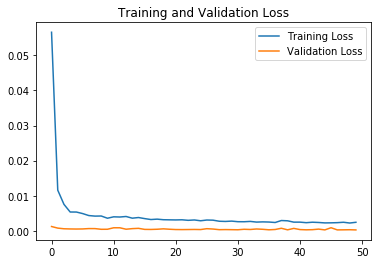

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss') #验证集用来选则最佳的超参数的值
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'national debt Price Prediction')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'national debt Price')

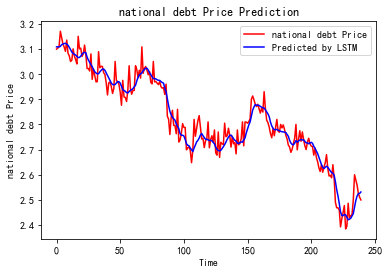

均方误差: 0.001433
均方根误差: 0.037856
平均绝对误差: 0.028925


In [11]:
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)

# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc_for_visual.inverse_transform(predicted_stock_price)

# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc_for_visual.inverse_transform(y_test_for_visual[60:])
# 画出真实数据和预测数据的对比曲线
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='national debt Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted by LSTM')
plt.title('national debt Price Prediction')
plt.xlabel('Time')
plt.ylabel('national debt Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

In [10]:
from sklearn.metrics import explained_variance_score
import seaborn as sns

cm = explained_variance_score(real_stock_price, predicted_stock_price)

print(cm )

0.9538690407527171
